## 1. Import Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Configuration

In [25]:
# Configuration
DATASET_DIR = Path(r"c:\Users\ananyas\OneDrive - Synopsys, Inc\Documents\iisc\subject\semester 1\data science in practice\project\dataset")
TRAIN_SPLIT_RATIO = 0.8
N_CLUSTERS = 4
RANDOM_STATE = 42

print("Configuration:")
print(f"  Dataset Directory: {DATASET_DIR}")
print(f"  Train Split Ratio: {TRAIN_SPLIT_RATIO}")
print(f"  Number of Clusters: {N_CLUSTERS}")
print(f"  Random State: {RANDOM_STATE}")

Configuration:
  Dataset Directory: c:\Users\ananyas\OneDrive - Synopsys, Inc\Documents\iisc\subject\semester 1\data science in practice\project\dataset
  Train Split Ratio: 0.8
  Number of Clusters: 4
  Random State: 42


## 3. Load and Prepare Data

In [26]:
# Get all CSV files (exclude feature files)
csv_files = [f for f in DATASET_DIR.glob("*.csv") if "features" not in f.name.lower()]

print(f"Found {len(csv_files)} CSV files:")
for file in csv_files[:10]:  # Show first 10
    print(f"  - {file.name}")
if len(csv_files) > 10:
    print(f"  ... and {len(csv_files) - 10} more files")

Found 8 CSV files:
  - ADANIGREEN_minute.csv
  - ADANIPOWER_minute.csv
  - BALKRISIND_minute.csv
  - HDFCAMC_minute.csv
  - ICICIGI_minute.csv
  - ICICIPRULI_minute.csv
  - JSWENERGY_minute.csv
  - NAUKRI_minute.csv


In [27]:
# Load datasets and split into train/test
train_datasets = {}
test_datasets = {}

for file in csv_files:
    stock_name = file.stem.replace('_minute', '')
    df = pd.read_csv(file)
    
    # Standardize column names to lowercase
    df.columns = df.columns.str.lower()
    
    # Ensure datetime column
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
    elif 'date' in df.columns:
        df['datetime'] = pd.to_datetime(df['date'])
    elif 'time' in df.columns:
        df['datetime'] = pd.to_datetime(df['time'])
    else:
        df['datetime'] = pd.to_datetime(df.index)
    
    df = df.sort_values('datetime').reset_index(drop=True)
    
    # Split into train and test
    split_idx = int(len(df) * TRAIN_SPLIT_RATIO)
    train_datasets[stock_name] = df.iloc[:split_idx].copy()
    test_datasets[stock_name] = df.iloc[split_idx:].copy()

print(f"\n✓ Loaded and split {len(train_datasets)} stocks")
print(f"\nSample split for first stock ({list(train_datasets.keys())[0]}):")
sample_stock = list(train_datasets.keys())[0]
print(f"  Training records: {len(train_datasets[sample_stock])} ({TRAIN_SPLIT_RATIO*100:.0f}%)")
print(f"  Testing records: {len(test_datasets[sample_stock])} ({(1-TRAIN_SPLIT_RATIO)*100:.0f}%)")


✓ Loaded and split 8 stocks

Sample split for first stock (ADANIGREEN):
  Training records: 524984 (80%)
  Testing records: 131246 (20%)


## 4. Extract Pattern-Based Features

Extract 16 technical and time series features from each stock's training data.

In [28]:
def extract_pattern_features(df, stock_name):
    """
    Extract pattern-based features from stock data.
    
    Returns a dictionary with 16 features capturing:
    - Trend characteristics
    - Volatility patterns
    - Momentum indicators
    - Volume patterns
    - Persistence (autocorrelation)
    - Price action patterns
    - Distribution shape
    """
    df = df.copy()
    df = df.sort_values('datetime')
    
    # Calculate returns and price changes
    df['returns'] = df['close'].pct_change()
    df['price_change'] = df['close'] - df['open']
    df['high_low_range'] = df['high'] - df['low']
    
    # 1. TREND FEATURES
    df['sma_20'] = df['close'].rolling(window=20, min_periods=1).mean()
    df['sma_50'] = df['close'].rolling(window=50, min_periods=1).mean()
    df['price_vs_sma20'] = (df['close'] - df['sma_20']) / df['sma_20']
    df['price_vs_sma50'] = (df['close'] - df['sma_50']) / df['sma_50']
    trend_direction = (df['sma_20'] > df['sma_50']).mean()
    
    # 2. VOLATILITY PATTERNS
    df['rolling_vol_20'] = df['returns'].rolling(window=20, min_periods=1).std()
    df['intraday_range'] = (df['high'] - df['low']) / df['open']
    
    # 3. MOMENTUM FEATURES
    df['roc_10'] = df['close'].pct_change(periods=10)
    positive_days_ratio = (df['price_change'] > 0).mean()
    
    # 4. VOLUME PATTERNS
    df['volume_ma'] = df['volume'].rolling(window=20, min_periods=1).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma']
    volume_trend = df['volume'].diff().mean() / df['volume'].mean() if df['volume'].mean() > 0 else 0
    
    # 5. AUTOCORRELATION (persistence)
    autocorr_1 = df['returns'].autocorr(lag=1) if len(df) > 1 else 0
    autocorr_5 = df['returns'].autocorr(lag=5) if len(df) > 1 else 0
    
    # 6. PRICE ACTION PATTERNS
    df['gap'] = df['open'] - df['close'].shift(1)
    avg_gap = df['gap'].mean()
    
    df['large_move'] = abs(df['returns']) > df['returns'].std()
    df['reversal'] = (df['returns'] * df['returns'].shift(-1)) < 0
    reversal_ratio = df[df['large_move']]['reversal'].mean() if df['large_move'].sum() > 0 else 0
    
    # Aggregate pattern features
    pattern_features = {
        'stock_name': stock_name,
        'trend_direction': trend_direction,
        'avg_price_vs_sma20': df['price_vs_sma20'].mean(),
        'avg_price_vs_sma50': df['price_vs_sma50'].mean(),
        'avg_rolling_volatility': df['rolling_vol_20'].mean(),
        'volatility_of_volatility': df['rolling_vol_20'].std(),
        'avg_intraday_range': df['intraday_range'].mean(),
        'momentum_roc': df['roc_10'].mean(),
        'positive_days_ratio': positive_days_ratio,
        'volume_trend': volume_trend,
        'avg_volume_ratio': df['volume_ratio'].mean(),
        'autocorr_lag1': autocorr_1 if not np.isnan(autocorr_1) else 0,
        'autocorr_lag5': autocorr_5 if not np.isnan(autocorr_5) else 0,
        'avg_gap': avg_gap,
        'reversal_tendency': reversal_ratio if not np.isnan(reversal_ratio) else 0,
        'skewness_returns': df['returns'].skew(),
        'kurtosis_returns': df['returns'].kurtosis()
    }
    
    return pattern_features

print("✓ Feature extraction function defined")

✓ Feature extraction function defined


In [29]:
# Extract features from all stocks
pattern_features_list = []

for stock_name, df in train_datasets.items():
    features = extract_pattern_features(df, stock_name)
    pattern_features_list.append(features)

# Convert to DataFrame
features_df = pd.DataFrame(pattern_features_list)

print(f"✓ Extracted features from {len(features_df)} stocks")
print(f"\nFeature columns ({len(features_df.columns) - 1} features):")
for col in features_df.columns:
    if col != 'stock_name':
        print(f"  - {col}")

print(f"\nFirst 5 stocks:")
features_df.head()

✓ Extracted features from 8 stocks

Feature columns (16 features):
  - trend_direction
  - avg_price_vs_sma20
  - avg_price_vs_sma50
  - avg_rolling_volatility
  - volatility_of_volatility
  - avg_intraday_range
  - momentum_roc
  - positive_days_ratio
  - volume_trend
  - avg_volume_ratio
  - autocorr_lag1
  - autocorr_lag5
  - avg_gap
  - reversal_tendency
  - skewness_returns
  - kurtosis_returns

First 5 stocks:


,stock_name,trend_direction,avg_price_vs_sma20,avg_price_vs_sma50,avg_rolling_volatility,volatility_of_volatility,avg_intraday_range,momentum_roc,positive_days_ratio,volume_trend,avg_volume_ratio,autocorr_lag1,autocorr_lag5,avg_gap,reversal_tendency,skewness_returns,kurtosis_returns
0,ADANIGREEN,0.440225,0.000081,0.000209,0.001616,0.001829,0.001833,0.000102,0.357716,-6.081112e-04,1.035082,-0.090338,0.001177,0.008459,0.506480,0.997481,261.420522
1,ADANIPOWER,0.457172,0.000024,0.000063,0.001669,0.001363,0.002185,0.000039,0.301621,-5.040458e-06,1.037498,-0.102256,0.001957,0.000386,0.477181,-0.589306,208.950457
2,BALKRISIND,0.491883,0.000114,0.000339,0.001127,0.003262,0.001222,inf,0.396408,8.671590e-07,1.046469,0.000000,0.000000,0.003502,0.000000,NaN,NaN
3,HDFCAMC,0.493980,0.000016,0.000042,0.000875,0.000803,0.001164,0.000022,0.445804,-3.100774e-03,1.033063,-0.050834,-0.004611,0.007919,0.545225,-3.658486,863.928904
4,ICICIGI,0.493837,0.000014,0.000037,0.000978,0.000888,0.001252,0.000020,0.437478,-3.134257e-03,1.034525,-0.049341,-0.009559,0.001522,0.550995,-2.289210,414.126153


## 5. Prepare Data for Clustering

In [30]:
# Separate stock names and numerical features
stock_names = features_df['stock_name'].values
feature_columns = [col for col in features_df.columns if col != 'stock_name']
X = features_df[feature_columns].values

# Replace NaN and inf values
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Number of stocks: {len(stock_names)}")
print(f"Number of features: {len(feature_columns)}")

Feature matrix shape: (8, 16)
Number of stocks: 8
Number of features: 16


## 6. Determine Optimal Number of Clusters (Elbow Method)

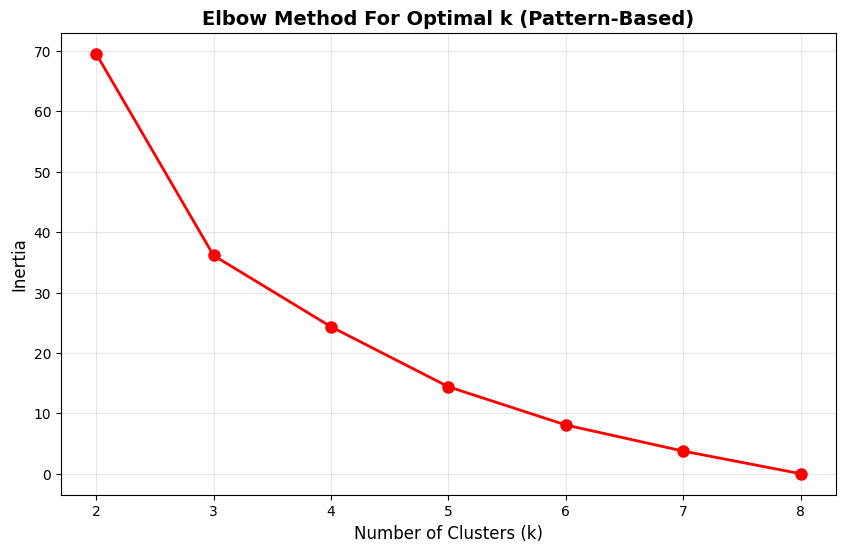

Inertia values for different k:
  k=2: 69.54
  k=3: 36.14
  k=4: 24.34
  k=5: 14.40
  k=6: 8.07
  k=7: 3.75
  k=8: 0.00


In [31]:
# Elbow method to find optimal k
inertias = []
K_range = range(2, min(9, len(stock_names) + 1))  # Adjust range based on number of stocks

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method For Optimal k (Pattern-Based)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.show()

print("Inertia values for different k:")
for k, inertia in zip(K_range, inertias):
    print(f"  k={k}: {inertia:.2f}")

## 7. Perform K-Means Clustering

In [32]:
# Perform clustering with optimal k
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Create results dataframe
results_df = features_df.copy()
results_df['cluster'] = cluster_labels
results_df = results_df.sort_values('cluster')

print(f"\n{'='*100}")
print(f"PATTERN-BASED CLUSTERING RESULTS (k={N_CLUSTERS})")
print(f"{'='*100}")

for cluster_id in range(N_CLUSTERS):
    cluster_stocks = results_df[results_df['cluster'] == cluster_id]['stock_name'].tolist()
    print(f"\nCluster {cluster_id} ({len(cluster_stocks)} stocks):")
    print(f"  {', '.join(cluster_stocks[:10])}")
    if len(cluster_stocks) > 10:
        print(f"  ... and {len(cluster_stocks) - 10} more stocks")

print(f"\n{'='*100}")


PATTERN-BASED CLUSTERING RESULTS (k=4)

Cluster 0 (1 stocks):
  BALKRISIND

Cluster 1 (3 stocks):
  HDFCAMC, ICICIPRULI, ICICIGI

Cluster 2 (2 stocks):
  ADANIGREEN, ADANIPOWER

Cluster 3 (2 stocks):
  JSWENERGY, NAUKRI



## 8. Analyze Cluster Characteristics

In [33]:
print("\n" + "="*100)
print("PATTERN-BASED CLUSTER ANALYSIS - DETAILED CHARACTERISTICS")
print("="*100)

for cluster_id in range(N_CLUSTERS):
    cluster_data = results_df[results_df['cluster'] == cluster_id]
    
    print(f"\n{'#'*100}")
    print(f"### CLUSTER {cluster_id}: {len(cluster_data)} Stocks")
    print(f"{'#'*100}")
    
    print(f"\nStocks: {', '.join(cluster_data['stock_name'].tolist()[:10])}")
    if len(cluster_data) > 10:
        print(f"        ... and {len(cluster_data) - 10} more")
    
    print(f"\n--- TREND CHARACTERISTICS ---")
    print(f"  Trend Direction (% time in uptrend): {cluster_data['trend_direction'].mean():.2%}")
    print(f"  Price vs 20-period MA: {cluster_data['avg_price_vs_sma20'].mean():.4f}")
    print(f"  Price vs 50-period MA: {cluster_data['avg_price_vs_sma50'].mean():.4f}")
    
    print(f"\n--- VOLATILITY PATTERNS ---")
    print(f"  Average Rolling Volatility: {cluster_data['avg_rolling_volatility'].mean():.6f}")
    print(f"  Volatility of Volatility: {cluster_data['volatility_of_volatility'].mean():.6f}")
    print(f"  Average Intraday Range: {cluster_data['avg_intraday_range'].mean():.6f}")
    
    print(f"\n--- MOMENTUM & DIRECTION ---")
    print(f"  Rate of Change (10-period): {cluster_data['momentum_roc'].mean():.6f}")
    print(f"  Positive Days Ratio: {cluster_data['positive_days_ratio'].mean():.2%}")
    
    print(f"\n--- VOLUME PATTERNS ---")
    print(f"  Volume Trend: {cluster_data['volume_trend'].mean():.6f}")
    print(f"  Average Volume Ratio: {cluster_data['avg_volume_ratio'].mean():.4f}")
    
    print(f"\n--- PERSISTENCE & MEMORY ---")
    print(f"  Autocorrelation (lag 1): {cluster_data['autocorr_lag1'].mean():.4f}")
    print(f"  Autocorrelation (lag 5): {cluster_data['autocorr_lag5'].mean():.4f}")
    
    print(f"\n--- PRICE ACTION ---")
    print(f"  Average Gap: {cluster_data['avg_gap'].mean():.6f}")
    print(f"  Reversal Tendency: {cluster_data['reversal_tendency'].mean():.4f}")
    
    print(f"\n--- DISTRIBUTION SHAPE ---")
    print(f"  Returns Skewness: {cluster_data['skewness_returns'].mean():.4f}")
    print(f"  Returns Kurtosis: {cluster_data['kurtosis_returns'].mean():.4f}")
    
    # Interpretation
    print(f"\n--- CLUSTER INTERPRETATION ---")
    
    trend_score = cluster_data['trend_direction'].mean()
    volatility_score = cluster_data['avg_rolling_volatility'].mean()
    momentum_score = cluster_data['momentum_roc'].mean()
    autocorr_avg = cluster_data['autocorr_lag1'].mean()
    
    behavior_type = []
    
    if trend_score > 0.55:
        behavior_type.append("Strong Uptrend")
    elif trend_score < 0.45:
        behavior_type.append("Strong Downtrend")
    else:
        behavior_type.append("Range-Bound/Sideways")
    
    if volatility_score > results_df['avg_rolling_volatility'].median():
        behavior_type.append("High Volatility")
    else:
        behavior_type.append("Low Volatility")
    
    if momentum_score > 0:
        behavior_type.append("Positive Momentum")
    else:
        behavior_type.append("Negative Momentum")
    
    if abs(autocorr_avg) > 0.1:
        if autocorr_avg > 0:
            behavior_type.append("Trend-Following (Persistent)")
        else:
            behavior_type.append("Mean-Reverting")
    else:
        behavior_type.append("Random Walk")
    
    print(f"  Pattern Type: {' | '.join(behavior_type)}")

print(f"\n{'='*100}\n")


PATTERN-BASED CLUSTER ANALYSIS - DETAILED CHARACTERISTICS

####################################################################################################
### CLUSTER 0: 1 Stocks
####################################################################################################

Stocks: BALKRISIND

--- TREND CHARACTERISTICS ---
  Trend Direction (% time in uptrend): 49.19%
  Price vs 20-period MA: 0.0001
  Price vs 50-period MA: 0.0003

--- VOLATILITY PATTERNS ---
  Average Rolling Volatility: 0.001127
  Volatility of Volatility: 0.003262
  Average Intraday Range: 0.001222

--- MOMENTUM & DIRECTION ---
  Rate of Change (10-period): inf
  Positive Days Ratio: 39.64%

--- VOLUME PATTERNS ---
  Volume Trend: 0.000001
  Average Volume Ratio: 1.0465

--- PERSISTENCE & MEMORY ---
  Autocorrelation (lag 1): 0.0000
  Autocorrelation (lag 5): 0.0000

--- PRICE ACTION ---
  Average Gap: 0.003502
  Reversal Tendency: 0.0000

--- DISTRIBUTION SHAPE ---
  Returns Skewness: nan
  Returns Kurt

## 9. Visualize Clusters

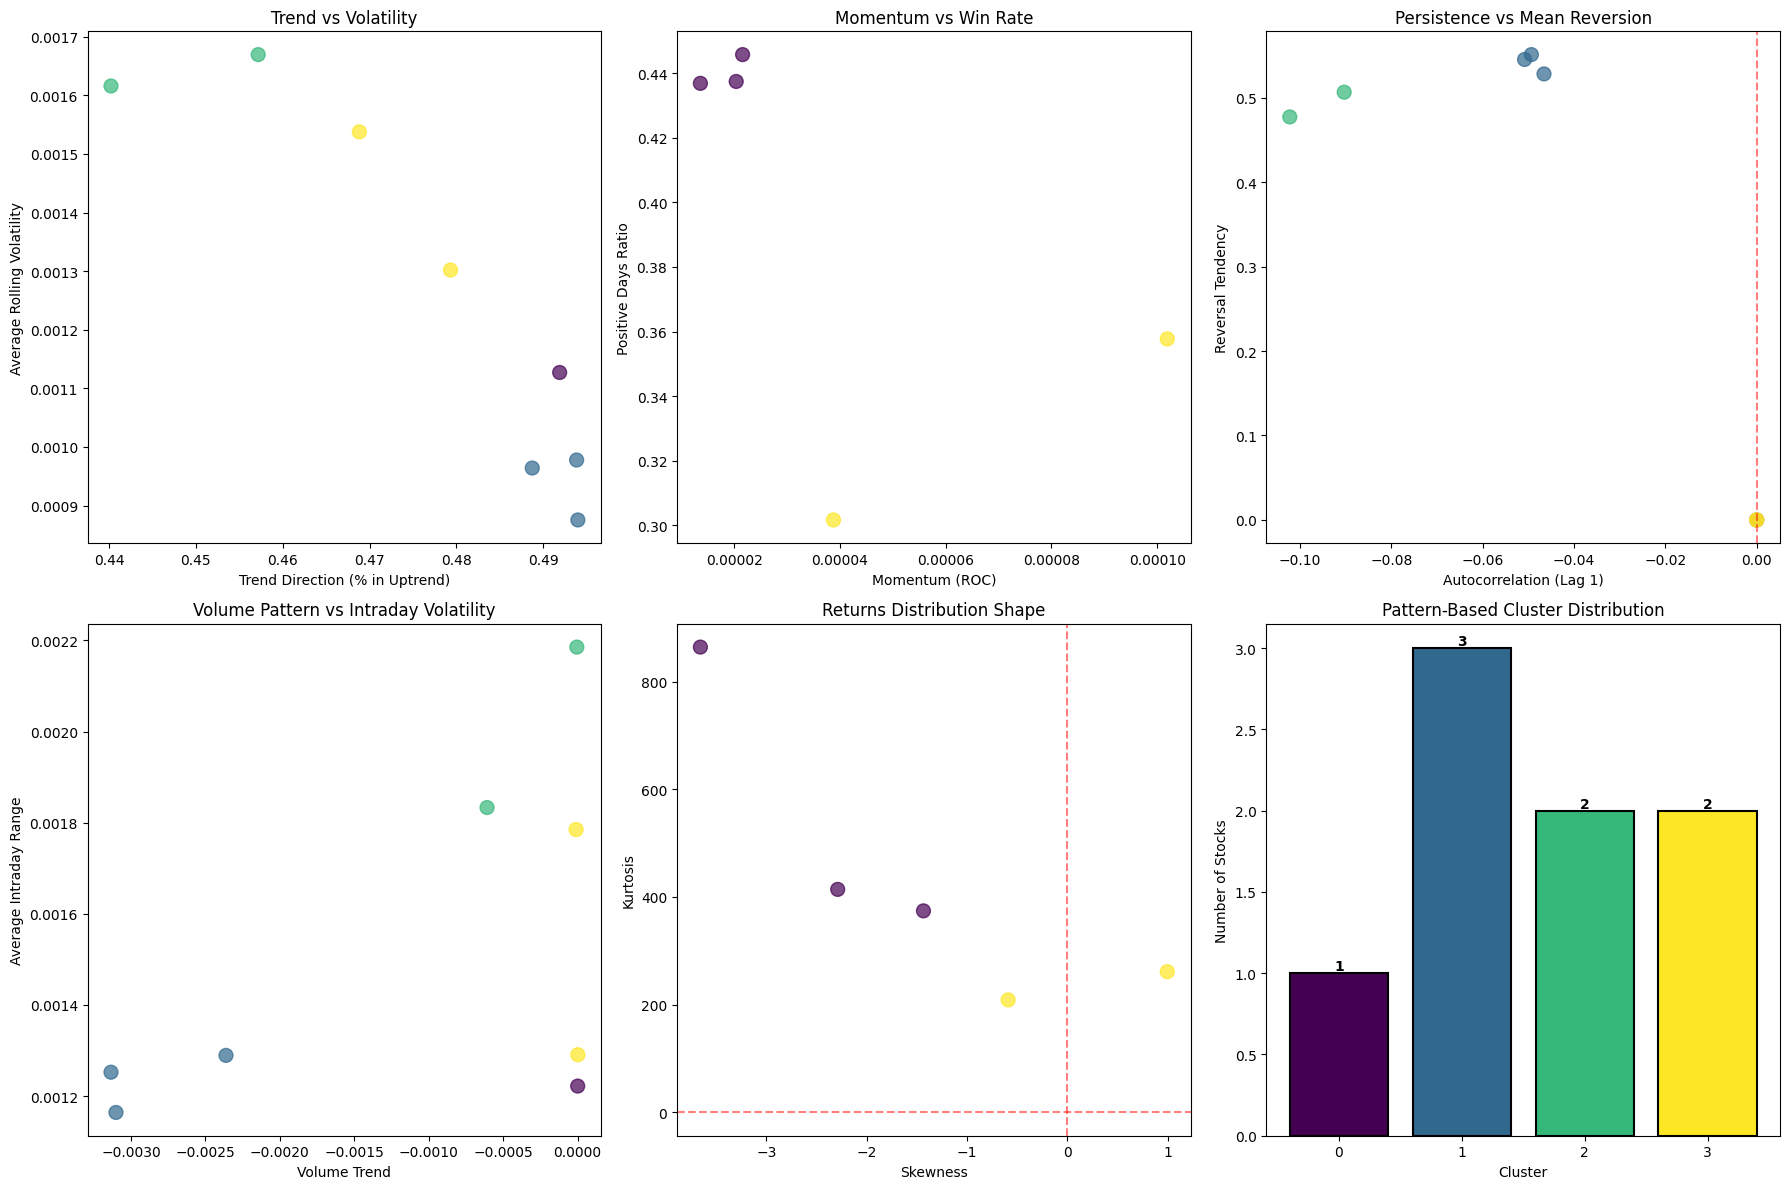

In [34]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot 1: Trend Direction vs Volatility
ax1 = axes[0, 0]
scatter1 = ax1.scatter(results_df['trend_direction'], 
                       results_df['avg_rolling_volatility'], 
                       c=results_df['cluster'], cmap='viridis', s=100, alpha=0.7)
ax1.set_xlabel('Trend Direction (% in Uptrend)')
ax1.set_ylabel('Average Rolling Volatility')
ax1.set_title('Trend vs Volatility')

# Plot 2: Momentum vs Positive Days Ratio
ax2 = axes[0, 1]
scatter2 = ax2.scatter(results_df['momentum_roc'], 
                       results_df['positive_days_ratio'], 
                       c=results_df['cluster'], cmap='viridis', s=100, alpha=0.7)
ax2.set_xlabel('Momentum (ROC)')
ax2.set_ylabel('Positive Days Ratio')
ax2.set_title('Momentum vs Win Rate')

# Plot 3: Autocorrelation (Persistence vs Mean Reversion)
ax3 = axes[0, 2]
scatter3 = ax3.scatter(results_df['autocorr_lag1'], 
                       results_df['reversal_tendency'], 
                       c=results_df['cluster'], cmap='viridis', s=100, alpha=0.7)
ax3.set_xlabel('Autocorrelation (Lag 1)')
ax3.set_ylabel('Reversal Tendency')
ax3.set_title('Persistence vs Mean Reversion')
ax3.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Plot 4: Volume Trend vs Intraday Range
ax4 = axes[1, 0]
scatter4 = ax4.scatter(results_df['volume_trend'], 
                       results_df['avg_intraday_range'], 
                       c=results_df['cluster'], cmap='viridis', s=100, alpha=0.7)
ax4.set_xlabel('Volume Trend')
ax4.set_ylabel('Average Intraday Range')
ax4.set_title('Volume Pattern vs Intraday Volatility')

# Plot 5: Returns Distribution Shape
ax5 = axes[1, 1]
scatter5 = ax5.scatter(results_df['skewness_returns'], 
                       results_df['kurtosis_returns'], 
                       c=results_df['cluster'], cmap='viridis', s=100, alpha=0.7)
ax5.set_xlabel('Skewness')
ax5.set_ylabel('Kurtosis')
ax5.set_title('Returns Distribution Shape')
ax5.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax5.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Plot 6: Cluster Distribution
ax6 = axes[1, 2]
cluster_counts = results_df['cluster'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, N_CLUSTERS))
bars = ax6.bar(cluster_counts.index, cluster_counts.values, 
               color=colors, edgecolor='black', linewidth=1.5)
ax6.set_xlabel('Cluster')
ax6.set_ylabel('Number of Stocks')
ax6.set_title('Pattern-Based Cluster Distribution')
ax6.set_xticks(range(N_CLUSTERS))

for bar in bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 9b. Cluster Membership Diagram

Visual representation of which stocks belong to each cluster.

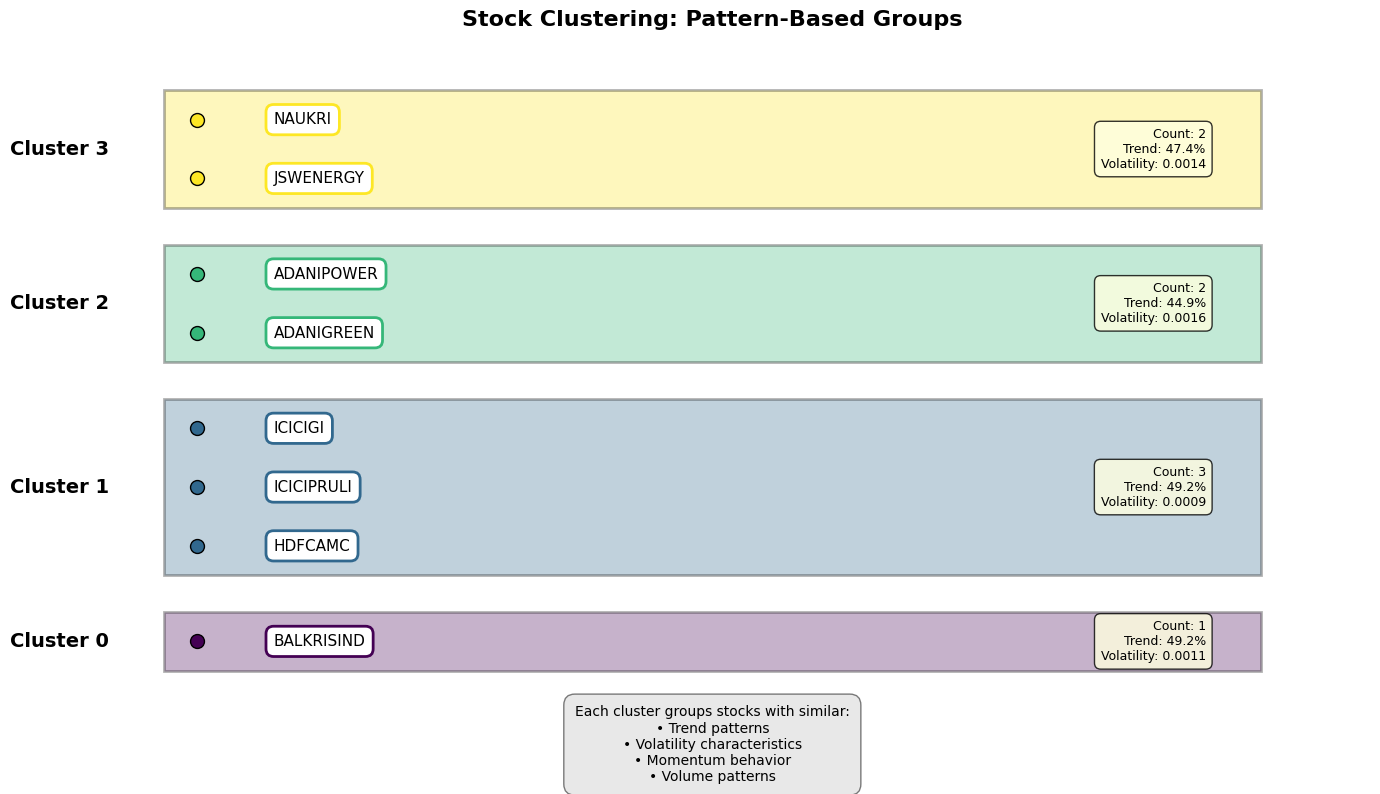


✓ Cluster membership diagram created with 4 clusters


In [35]:
# Create a visual cluster membership diagram
fig, ax = plt.subplots(figsize=(14, 8))

# Get cluster information
cluster_colors = plt.cm.viridis(np.linspace(0, 1, N_CLUSTERS))
y_position = 0
y_positions = []
cluster_labels_list = []

for cluster_id in range(N_CLUSTERS):
    cluster_stocks = results_df[results_df['cluster'] == cluster_id]['stock_name'].tolist()
    
    # Draw cluster box
    cluster_height = len(cluster_stocks) * 0.8
    rect = plt.Rectangle((0, y_position), 10, cluster_height, 
                         facecolor=cluster_colors[cluster_id], 
                         alpha=0.3, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    
    # Add cluster label
    ax.text(-0.5, y_position + cluster_height/2, f'Cluster {cluster_id}', 
           fontsize=14, fontweight='bold', va='center', ha='right')
    
    # Add stock names
    for i, stock in enumerate(cluster_stocks):
        stock_y = y_position + (i + 0.5) * 0.8
        ax.text(1, stock_y, stock, fontsize=11, va='center', 
               bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                        edgecolor=cluster_colors[cluster_id], linewidth=2))
        
        # Add a point marker
        ax.plot(0.3, stock_y, 'o', color=cluster_colors[cluster_id], 
               markersize=10, markeredgecolor='black', markeredgewidth=1)
    
    # Add cluster info
    cluster_data = results_df[results_df['cluster'] == cluster_id]
    info_text = f"Count: {len(cluster_stocks)}\n"
    info_text += f"Trend: {cluster_data['trend_direction'].mean():.1%}\n"
    info_text += f"Volatility: {cluster_data['avg_rolling_volatility'].mean():.4f}"
    
    ax.text(9.5, y_position + cluster_height/2, info_text, 
           fontsize=9, va='center', ha='right',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))
    
    y_position += cluster_height + 0.5

# Set plot properties
ax.set_xlim(-1, 11)
ax.set_ylim(-0.5, y_position)
ax.set_aspect('auto')
ax.axis('off')
ax.set_title('Stock Clustering: Pattern-Based Groups', fontsize=16, fontweight='bold', pad=20)

# Add legend
legend_text = "Each cluster groups stocks with similar:\n"
legend_text += "• Trend patterns\n• Volatility characteristics\n"
legend_text += "• Momentum behavior\n• Volume patterns"
ax.text(5, -1.5, legend_text, fontsize=10, ha='center',
       bbox=dict(boxstyle='round,pad=0.8', facecolor='lightgray', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\n✓ Cluster membership diagram created with {N_CLUSTERS} clusters")

## 9c. Cluster Scatter Plot (PCA Visualization)

Use PCA to reduce features to 2D and visualize cluster separation.

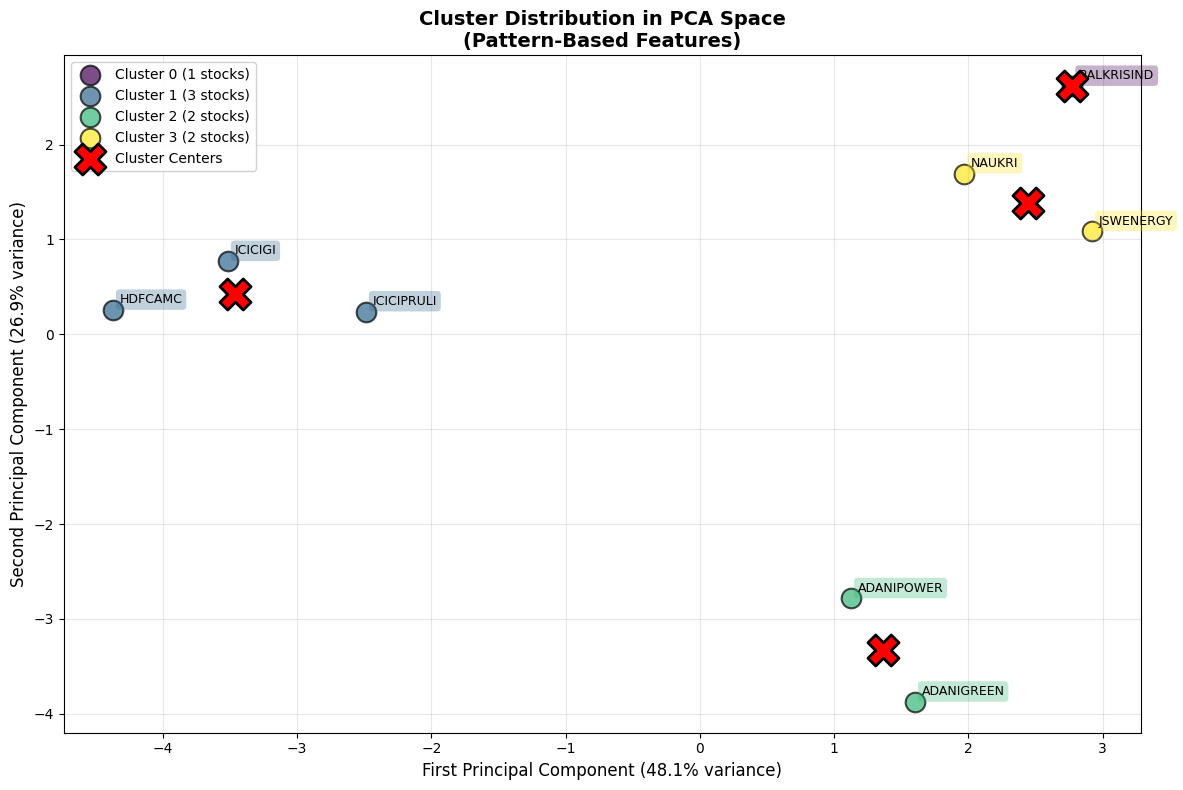


✓ PCA scatter plot created
  Total variance explained by 2 components: 75.0%
  PC1 explains: 48.1%
  PC2 explains: 26.9%


In [36]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

# Create scatter plot
plt.figure(figsize=(12, 8))

# Plot each cluster with different colors
cluster_colors = plt.cm.viridis(np.linspace(0, 1, N_CLUSTERS))

for cluster_id in range(N_CLUSTERS):
    cluster_mask = cluster_labels == cluster_id
    cluster_stocks = stock_names[cluster_mask]
    
    plt.scatter(X_pca[cluster_mask, 0], 
               X_pca[cluster_mask, 1],
               c=[cluster_colors[cluster_id]], 
               label=f'Cluster {cluster_id} ({len(cluster_stocks)} stocks)',
               s=200, 
               alpha=0.7,
               edgecolors='black',
               linewidth=1.5)
    
    # Add stock name labels
    for i, stock_idx in enumerate(np.where(cluster_mask)[0]):
        plt.annotate(stock_names[stock_idx], 
                    (X_pca[stock_idx, 0], X_pca[stock_idx, 1]),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor=cluster_colors[cluster_id], 
                            alpha=0.3,
                            edgecolor='none'))

# Plot cluster centers in PCA space
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
           c='red', marker='X', s=500, 
           edgecolors='black', linewidth=2,
           label='Cluster Centers', zorder=5)

plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
plt.title('Cluster Distribution in PCA Space\n(Pattern-Based Features)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

total_variance = pca.explained_variance_ratio_.sum()
print(f"\n✓ PCA scatter plot created")
print(f"  Total variance explained by 2 components: {total_variance:.1%}")
print(f"  PC1 explains: {pca.explained_variance_ratio_[0]:.1%}")
print(f"  PC2 explains: {pca.explained_variance_ratio_[1]:.1%}")

## 10. Save Results

In [37]:
# Save results to CSV
output_file = DATASET_DIR.parent / 'pattern_clustering_results.csv'
results_df.to_csv(output_file, index=False)

print(f"✓ Results saved to: {output_file}")
print(f"\nSaved {len(results_df)} stocks with {N_CLUSTERS} cluster assignments")

✓ Results saved to: c:\Users\ananyas\OneDrive - Synopsys, Inc\Documents\iisc\subject\semester 1\data science in practice\project\pattern_clustering_results.csv

Saved 8 stocks with 4 cluster assignments


## 11. Cluster Summary

In [38]:
print("\n" + "="*100)
print("CLUSTER MEMBERSHIP SUMMARY")
print("="*100)

for cluster_id in range(N_CLUSTERS):
    stocks = results_df[results_df['cluster'] == cluster_id]['stock_name'].tolist()
    print(f"\nCluster {cluster_id} ({len(stocks)} stocks):")
    print(f"  {', '.join(stocks[:15])}")
    if len(stocks) > 15:
        print(f"  ... and {len(stocks) - 15} more stocks")

print("\n" + "="*100)


CLUSTER MEMBERSHIP SUMMARY

Cluster 0 (1 stocks):
  BALKRISIND

Cluster 1 (3 stocks):
  HDFCAMC, ICICIPRULI, ICICIGI

Cluster 2 (2 stocks):
  ADANIGREEN, ADANIPOWER

Cluster 3 (2 stocks):
  JSWENERGY, NAUKRI



## 12. View Results DataFrame

In [39]:
# Display first 20 rows of results
results_df.head(20)

,stock_name,trend_direction,avg_price_vs_sma20,avg_price_vs_sma50,avg_rolling_volatility,volatility_of_volatility,avg_intraday_range,momentum_roc,positive_days_ratio,volume_trend,avg_volume_ratio,autocorr_lag1,autocorr_lag5,avg_gap,reversal_tendency,skewness_returns,kurtosis_returns,cluster
2,BALKRISIND,0.491883,0.000114,0.000339,0.001127,0.003262,0.001222,inf,0.396408,8.671590e-07,1.046469,0.000000,0.000000,0.003502,0.000000,NaN,NaN,0
3,HDFCAMC,0.493980,0.000016,0.000042,0.000875,0.000803,0.001164,0.000022,0.445804,-3.100774e-03,1.033063,-0.050834,-0.004611,0.007919,0.545225,-3.658486,863.928904,1
5,ICICIPRULI,0.488729,0.000009,0.000022,0.000964,0.000753,0.001289,0.000014,0.436899,-2.361805e-03,1.032590,-0.046576,-0.000494,0.001234,0.528152,-1.433817,374.264041,1
4,ICICIGI,0.493837,0.000014,0.000037,0.000978,0.000888,0.001252,0.000020,0.437478,-3.134257e-03,1.034525,-0.049341,-0.009559,0.001522,0.550995,-2.289210,414.126153,1
0,ADANIGREEN,0.440225,0.000081,0.000209,0.001616,0.001829,0.001833,0.000102,0.357716,-6.081112e-04,1.035082,-0.090338,0.001177,0.008459,0.506480,0.997481,261.420522,2
1,ADANIPOWER,0.457172,0.000024,0.000063,0.001669,0.001363,0.002185,0.000039,0.301621,-5.040458e-06,1.037498,-0.102256,0.001957,0.000386,0.477181,-0.589306,208.950457,2
6,JSWENERGY,0.468824,0.000055,0.000195,0.001538,0.002138,0.001785,inf,0.328582,-9.921539e-06,1.049004,0.000000,0.000000,0.000173,0.000000,NaN,NaN,3
7,NAUKRI,0.479314,0.000023,0.000059,0.001302,0.001571,0.001291,inf,0.215750,1.977992e-06,1.050155,0.000000,0.000000,0.002310,0.000000,NaN,NaN,3


In [40]:
# Summary statistics by cluster
summary_cols = ['trend_direction', 'avg_rolling_volatility', 'momentum_roc', 
                'positive_days_ratio', 'autocorr_lag1']

print("\nCluster Summary Statistics:")
results_df.groupby('cluster')[summary_cols].mean()


Cluster Summary Statistics:


,trend_direction,avg_rolling_volatility,momentum_roc,positive_days_ratio,autocorr_lag1
cluster,,,,,
0,0.491883,0.001127,inf,0.396408,0.000000
1,0.492182,0.000939,0.000019,0.440060,-0.048917
2,0.448699,0.001643,0.000070,0.329668,-0.096297
3,0.474069,0.001420,inf,0.272166,0.000000
